In [22]:
%pip install 'monai[all]'

Defaulting to user installation because normal site-packages is not writeable
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached PyJWT-2.9.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Preparing metadata (setup.py) ... done
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.1 MB/s eta 0:00:00
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 136.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 79.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 104.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 75.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 103.0 MB/s 

In [17]:
import os
import random
import shutil
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
import monai.transforms as mt
import torch.nn as nn
from torch.optim import Adam
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, pad_list_data_collate
from PIL import Image
import wandb

In [18]:
sitk.ProcessObject.SetGlobalWarningDisplay(False)  # Suppress ITK warnings

### Load your data paths for train and val sets into memory

In [19]:
train_dir = '../dataset/dataset_extracted/train_split'
val_dir = '../dataset/dataset_extracted/val_split'
test_dir='../dataset/dataset_extracted/test'


train_data_3d = []
for patient in os.listdir(train_dir):
    patient_path = os.path.join(train_dir, patient)
    
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith(".nii") and "_gt" not in file:  # Select only image files
                img_path = os.path.join(patient_path, file)
                gt_path = os.path.join(patient_path, file.replace(".nii", "_gt.nii"))  # Expected ground truth file

                if os.path.exists(gt_path):  # Ensure ground truth file exists
                    train_data_3d.append({"img": img_path, "mask": gt_path})
                    

val_data_3d = []
for patient in os.listdir(val_dir):
    patient_path = os.path.join(val_dir, patient)
    
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith(".nii") and "_gt" not in file:  # Select only image files
                img_path = os.path.join(patient_path, file)
                gt_path = os.path.join(patient_path, file.replace(".nii", "_gt.nii"))  # Expected ground truth file

                if os.path.exists(gt_path):  # Ensure ground truth file exists
                    val_data_3d.append({"img": img_path, "mask": gt_path})
                    
                    
test_data_3d = []
for patient in os.listdir(test_dir):
    patient_path = os.path.join(test_dir, patient)

    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith(".nii") and "_gt" not in file:  # Select only image files
                img_path = os.path.join(patient_path, file)
                gt_path = os.path.join(patient_path, file.replace(".nii", "_gt.nii"))  # Expected ground truth file
                
                if os.path.exists(gt_path):  # Ensure ground truth file exists
                    # Extract patient ID and frame number
                    parts = file.split("_")  # Example: patient140_frame05.nii → ["patient140", "frame05.nii"]
                    patient_id = parts[0]  # "patient140"
                    frame_number = parts[1].replace(".nii", "")  # "frame05"

                    test_data_3d.append({
                        "img": img_path,
                        "mask": gt_path,
                        "patient_id": patient_id,
                        "frame": frame_number
                    })



In [21]:
test_data_3d[4]

{'img': '../dataset/dataset_extracted/test/patient102/patient102_frame13.nii',
 'mask': '../dataset/dataset_extracted/test/patient102/patient102_frame13_gt.nii',
 'patient_id': 'patient102',
 'frame': 'frame13'}

In [22]:
#Function for choosing device. Requires a gpu_id, which is an integer corresponding to the index of the gpu from the server
# If there is only one gpu on the server you are currently on, then the function will default to that, regardless to the gpu_id you are passing.
def choose_gpu(gpu_id):    
    num_gpus = torch.cuda.device_count()

    if num_gpus == 0:
        device = torch.device("cpu")  # No GPU available, fallback to CPU
        print("No GPU available, using CPU.")
    elif num_gpus == 1:
        device = torch.device("cuda:0")  # Only one GPU, use it
        print(f"Only one GPU found, using GPU 0: {torch.cuda.get_device_name(0)}")
    else:
        gpu_id = gpu_id  # User-defined GPU index
        if gpu_id >= num_gpus:  # Ensure the selected GPU is valid
            print(f"Invalid GPU ID {gpu_id}, defaulting to GPU 0.")
            gpu_id = 0
        device = torch.device(f"cuda:{gpu_id}")
        print(f"Using GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
        
        return device

In [23]:
device=choose_gpu(1)

Using GPU 1: Tesla T4


### Some convenience functions for logging to wandb

In [5]:
from tqdm import tqdm
import wandb



def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Convert model output probabilities into class labels
    mask_output = torch.argmax(mask_output, dim=1)  # Get the class with the highest probability

    # Transform masks to numpy arrays on CPU
    print(f"mask_output shape in wandb_masks function before squeeze: {mask_output.shape}")
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    print(f"mask_output shape in wandb_masks function after squeeze: {mask_output.shape}")
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label mapping
    class_labels = {0: 'background', 1: 'c1', 2: 'c2', 3: 'c3'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks


def log_to_wandb(epoch, train_loss, val_loss, train_outputs, val_outputs):
    """ Function that logs ongoing training variables to W&B """

    def extract_2d_slice(volume):
        """Extract a middle slice from a 3D volume (H, W, D) → (H, W)"""
        return volume[..., volume.shape[-1] // 2]  # Take middle depth slice

    # Convert 3D images to 2D slices for W&B
    train_log_imgs = [
        wandb.Image(extract_2d_slice(img), masks=wandb_masks(extract_2d_slice(mask_output), extract_2d_slice(mask_gt)))
        for img, mask_output, mask_gt in zip(train_outputs['img'], train_outputs['output'], train_outputs['mask'])
    ]

    val_log_imgs = [
        wandb.Image(extract_2d_slice(img), masks=wandb_masks(extract_2d_slice(mask_output), extract_2d_slice(mask_gt)))
        for img, mask_output, mask_gt in zip(val_outputs['img'], val_outputs['output'], val_outputs['mask'])
    ]

    # Log to W&B
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_results': train_log_imgs,
        'val_results': val_log_imgs
    })

    
    
def from_compose_to_list(compose):
    """Extracts individual transforms from a Compose object and converts them to a loggable format."""
    return [get_config_info(t) for t in compose.transforms] if isinstance(compose, monai.transforms.Compose) else get_config_info(compose)

def get_config_info(obj):
    """Converts an object to a loggable format with name and parameters."""
    if hasattr(obj, '__dict__'):  
        return {'name': obj.__class__.__name__, 'params': vars(obj)}  # Object with attributes
    else:  
        return {'name': obj.__class__.__name__, 'params': str(obj)}  # Fallback for simple objects




### The training loop. Still needs improvement, since now it only works with dice loss.

In [6]:

def train_loop(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, device=device, val_freq=1):
    train_loss_list = []
    val_loss_list = []
    sitk.ProcessObject.SetGlobalWarningDisplay(False)

    for epoch in tqdm(range(epochs)):
        model.train()
        steps = 0
        epoch_loss = 0

        # Store a batch for logging train results
        train_batch = None
        train_output = None

        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['mask'].float().to(device)
            output = model(images) 
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1

            # Save one batch for visualization
            if train_batch is None:
                train_batch = batch
                train_output = output.detach().cpu()
                print(f"train_output shape in train loop: {train_output.shape}")

        train_loss = epoch_loss / steps     #should this be divided by step or by len(train_loader_3d)
        train_loss_list.append(train_loss)

        # Store training outputs for logging
        train_outputs = {
            'img': train_batch['img'],  
            'mask': train_batch['mask'],  
            'output': train_output  
        }

        # Validation loop
        val_loss = None  # Default if no validation happens
        val_outputs = {'img': None, 'mask': None, 'output': None}  # Default empty dict

        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            dice_metric.reset()

            val_batch = None
            val_output = None

            for batch in val_dataloader:
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                print(f"labels in val step train loop:{labels.shape}")
                output = model(images) 
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1

                # Save one batch for visualization
                if val_batch is None:
                    val_batch = batch
                    val_output = output.detach().cpu()
                    
                pred = torch.argmax(output, dim=1, keepdim=True)
                pred = monai.networks.utils.one_hot(pred, num_classes=4)
                dice_metric(y_pred=pred, y=labels)

            val_loss = val_epoch_loss / steps
            val_loss_list.append(val_loss)
            
            dice_score = dice_metric.aggregate().item()
            
            # Store validation outputs for logging
            val_outputs = {
                'img': val_batch['img'],  
                'mask': val_batch['mask'],  
                'output': val_output ,
                'Dice Score':dice_score
            }

        # Log to W&B
        log_to_wandb(epoch, train_loss, val_loss, train_outputs, val_outputs)

    return train_loss_list, val_loss_list, model





### The function you will use to train a model. This ensures the experiment parameters get logged to wandb.
### Returns the model, train loss, val loss and run_id for further use of these variables if desired.

In [7]:
def train_and_log(
    train_loop,  # Pass the training function
    model, train_dataloader, val_dataloader, optimizer, loss_function, metric, transforms, run_name, 
    project_name='ACDC', 
    path='./', epochs=10
):
    """Wrapper function to handle training and W&B logging."""

    
        # Function to calculate total parameters
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Extract model hyperparameters dynamically
    model_config = {
        "in_channels": getattr(model, "in_channels", None),
        "out_channels": getattr(model, "out_channels", None),
        "initial_features": model.channels[0] if hasattr(model, "channels") else None,
        "channels": getattr(model, "channels", None),
        "strides": getattr(model, "strides", None),
        "num_res_units": getattr(model, "num_res_units", None),
        "dropout": getattr(model, "dropout", None),  # Logs dropout if present
        "norm": getattr(model, "norm", None),  # Normalization type
        "activation": getattr(model, "act", None),  # Activation function
        "total_params": count_parameters(model),  # Total trainable parameters
    }
    
    
    wandb.login()
    
    # Initialize W&B Run
    run = wandb.init(
        project=project_name,
        name=run_name,
        config={
            **{k: v for k, v in model_config.items() if v is not None},  # Filter out None values
            'loss function': get_config_info(loss_function),  
            'optimizer': get_config_info(optimizer),
            'metric': get_config_info(metric),
            'batch_size': train_dataloader.batch_size,
            'transforms': from_compose_to_list(transforms)
        }
    )

    # Store run ID
    run_id = run.id  

    # Train the model
    train_loss, val_loss, trained_model = train_loop(
        model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, device
    )

    # Save model weights
    artifact_name= f'{run_name}.pt'
    model_path = f"{path}/{artifact_name}"
    torch.save(trained_model.state_dict(), model_path)

    # Create and log model artifact
    artifact = wandb.Artifact(name=artifact_name, type="model")
    artifact.add_file(model_path)  
    run.log_artifact(artifact)  # Log the artifact to the W&B run

    # Finish W&B run
    run.finish()

    return trained_model, train_loss, val_loss, run_id  # Return for further use


### Step 1: Create your desired transforms composition

In [24]:

transforms = mt.Compose([
    mt.LoadImaged(keys=['img', 'mask'], reader="ITKReader"),  # Load images/masks
    mt.EnsureChannelFirstd(keys=['img', 'mask']),  # Ensure channel first format
    # mt.ToMetaTensord(keys=["img", 'mask']),
    # mt.Spacingd(
    # keys=['img'], 
    # pixdim=target_resolution, 
    # mode='bilinear'  # Linear interpolation for images
    # ),
    # mt.Spacingd(
    #     keys=['mask'], 
    #     pixdim=target_resolution, 
    #     mode='nearest'  # Nearest-neighbor for masks to preserve labels
    # ),
    mt.SpatialPadd(keys=['img', 'mask'], spatial_size=(384, 344, 18)), # Pad to desired size
    mt.CenterSpatialCropd(keys=['img', 'mask'], roi_size=(256, 256, 16)), #enforce correct shapes
    monai.transforms.ScaleIntensityd(keys=['img'])
])

### Step 2: Load the data into a dataLoader. Here you can set the batch_size which will influence your training time and gpu usage. 
### We also visualise a batch below.

In [25]:
train_ds_3d = Dataset(data=train_data_3d, transform=transforms)
val_ds_3d = Dataset(data=val_data_3d, transform=transforms)
test_ds_3d=Dataset(data=test_data_3d, transform=transforms)

train_loader_3d = DataLoader(train_ds_3d, batch_size=5, shuffle=True, collate_fn=pad_list_data_collate)
val_loader_3d = DataLoader(val_ds_3d, batch_size=5, shuffle=False, collate_fn=pad_list_data_collate)
test_loader_3d=DataLoader(test_ds_3d, batch_size=5, shuffle=False, collate_fn=pad_list_data_collate)


In [8]:

sample_image_path = train_data_3d[0]['img']  # Get path to first training image
original_image = sitk.ReadImage(sample_image_path)

print("Original Spacing:", original_image.GetSpacing())  # Print original voxel spacing

# Load a sample from transformed dataset
sample_transformed = transforms(train_data_3d[0])  # Apply transformations
print("Transformed Spacing:", sample_transformed['img'].meta['spacing'])  # Print new voxel spacing


Original Spacing: (1.25, 1.25, 5.0)
Transformed Spacing: [1.25 1.25 5.  ]


In [26]:
batch=next(iter(test_loader_3d))

print(batch['img'].shape)
print(batch['mask'].shape)

# Extract the first sample in the batch (shape: [1, 384, 344, 18])
image = batch["img"][0, 0]  # First sample, remove batch & channel dims (shape: [384, 344, 18])
mask = batch["mask"][0, 0]  # First mask (shape: [384, 344, 18])

# Move to CPU if on GPU
if torch.cuda.is_available():
    image = image.cpu()
    mask = mask.cpu()

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient12

torch.Size([5, 1, 256, 256, 16])
torch.Size([5, 1, 256, 256, 16])


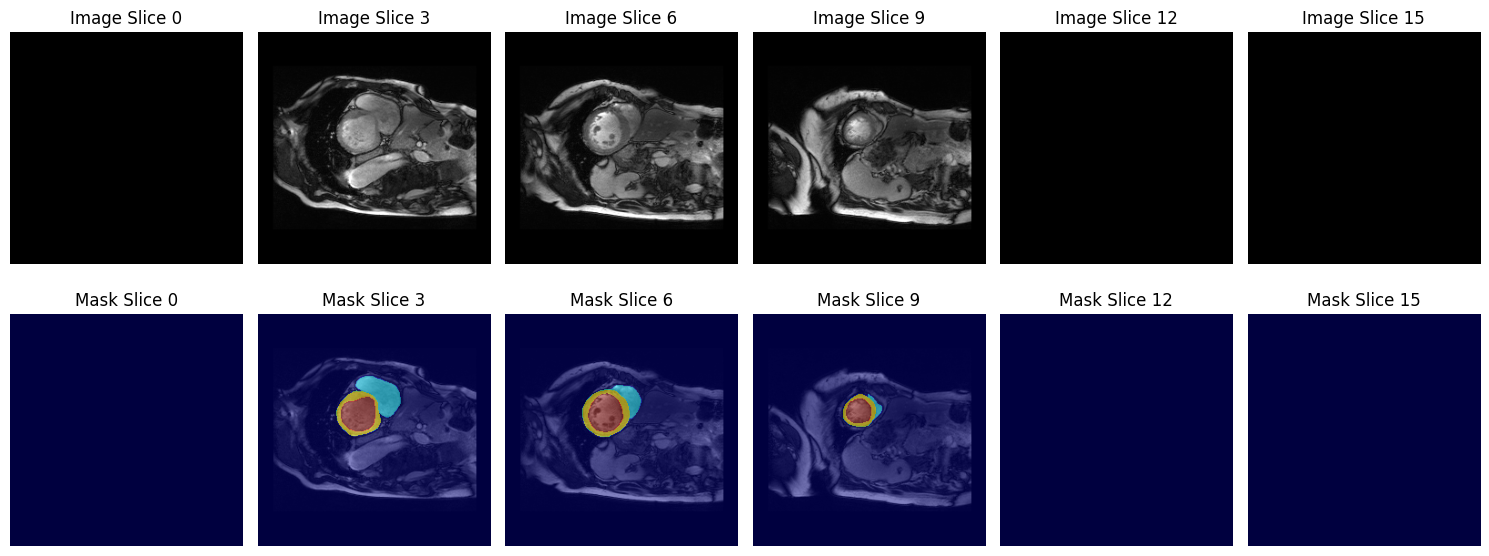

In [9]:
def plot_slices(image, mask, num_slices=6):
    """Function to plot selected slices from a 3D image and mask."""
    depth = image.shape[2]  # Number of slices
    slice_indices = torch.linspace(0, depth - 1, num_slices).int()  # Select `num_slices` evenly

    fig, axes = plt.subplots(2, num_slices, figsize=(15, 6))

    for i, slice_idx in enumerate(slice_indices):
        img_slice = image[:, :, slice_idx].numpy()  # Extract slice
        mask_slice = mask[:, :, slice_idx].numpy()  # Extract mask slice

        axes[0, i].imshow(img_slice, cmap="gray")
        axes[0, i].set_title(f"Image Slice {slice_idx}")
        axes[0, i].axis("off")

        axes[1, i].imshow(img_slice, cmap="gray")  # Base image
        axes[1, i].imshow(mask_slice, cmap="jet", alpha=0.5)  # Overlay mask
        axes[1, i].set_title(f"Mask Slice {slice_idx}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Plot slices
plot_slices(image, mask, num_slices=6)


### Step 3: Declare model you want to use and set hyperparameters

In [27]:
in_channels = 1
out_channels = 4
initial_features = 32

channels = (initial_features, initial_features*2, initial_features*4, initial_features*8)
strides = (2, 2, 1)   # Avoid excessive downsampling in depth
num_res_units = 2

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=num_res_units,
    norm="batch",
)

model.to(device)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [15]:
from torchsummary import summary

summary(model, (1, 256, 256, 16))  # (C, H, W, D)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 128, 128, 8]             896
            Conv3d-2      [-1, 32, 128, 128, 8]             896
       BatchNorm3d-3      [-1, 32, 128, 128, 8]              64
           Dropout-4      [-1, 32, 128, 128, 8]               0
             PReLU-5      [-1, 32, 128, 128, 8]               1
            Conv3d-6      [-1, 32, 128, 128, 8]          27,680
       BatchNorm3d-7      [-1, 32, 128, 128, 8]              64
           Dropout-8      [-1, 32, 128, 128, 8]               0
             PReLU-9      [-1, 32, 128, 128, 8]               1
     ResidualUnit-10      [-1, 32, 128, 128, 8]               0
           Conv3d-11        [-1, 64, 64, 64, 4]          55,360
           Conv3d-12        [-1, 64, 64, 64, 4]          55,360
      BatchNorm3d-13        [-1, 64, 64, 64, 4]             128
          Dropout-14        [-1, 64, 64

### Step 4: Set loss function, optimizer and performance metric.

In [13]:
class_weights = torch.tensor([0.031, 1.000, 0.988, 0.986], dtype=torch.float, device=device)

dice_loss =  monai.losses.DiceLoss(to_onehot_y=True, softmax=True, weight=class_weights)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

### Step 5: Now just train the model by using the function above.

In [14]:
epochs=2


trained_model, train_loss, val_loss, run_id = \
train_and_log(train_loop, model, train_loader_3d,
              val_loader_3d, adam_optimizer, dice_loss, dice_metric, transforms, run_name='3DUnet_adjusted_Weights', epochs=epochs)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: razvan-stanciu98 (razvan-stanciu98-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/2 [00:00<?, ?it/s]

train_output shape in train loop: torch.Size([5, 4, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])


NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e54cc30): ../datas

labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function aft

 50%|█████     | 1/2 [01:01<01:01, 61.26s/it]

train_output shape in train loop: torch.Size([5, 4, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])


NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../dataset/dataset_extracted/val_split/patient098/patient098_frame09_gt.nii has unexpected scales in sform

NiftiImageIO (0x55695e521a70): ../datas

labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
labels in val step train loop:torch.Size([5, 1, 256, 256, 16])
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function after squeeze: (4, 256)
mask_output shape in wandb_masks function before squeeze: torch.Size([4, 256])
mask_output shape in wandb_masks function aft

100%|██████████| 2/2 [01:44<00:00, 52.23s/it]


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,1
train_loss,0.66355
val_loss,0.67416


In [28]:
# Load model weights correctly
checkpoint = torch.load("../3DUnet_v1.pt", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint)  # Correct way

<All keys matched successfully>

In [15]:
import os
import numpy as np
import torch
import SimpleITK as sitk
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric, HausdorffDistanceMetric

# Create output directories if they don't exist
vis_output_dir = "prediction_visualizations"
seg_output_dir = "saved_segmentations"
os.makedirs(vis_output_dir, exist_ok=True)
os.makedirs(seg_output_dir, exist_ok=True)

# Ensure model is in evaluation mode
model.eval()

# Function to normalize images for visualization
def normalize_image(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) if np.max(img) > np.min(img) else img

# 1. Visualize predictions on a validation batch.
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader_3d):
        inputs = batch["img"].to(device)  # (B, 1, H, W, D)
        labels = batch["mask"].to(device)  # (B, 1, H, W, D)
        outputs = model(inputs)  # (B, num_classes, H, W, D)

        # Get predicted segmentation as argmax over class channels
        preds = torch.argmax(outputs, dim=1)  # (B, H, W, D)

        # Move to CPU & convert to NumPy
        inputs = inputs.cpu().numpy()
        labels = labels.cpu().numpy()
        preds = preds.cpu().numpy()

        # Iterate over batch samples
        for sample_idx in range(inputs.shape[0]):
            input_vol = inputs[sample_idx, 0]  # (H, W, D)
            label_vol = labels[sample_idx, 0]  # (H, W, D)
            pred_vol = preds[sample_idx]  # (H, W, D)

            num_slices = input_vol.shape[-1]

            for slice_idx in range(num_slices):
                fig, axs = plt.subplots(1, 2, figsize=(12, 4))

                # Original Image
                axs[0].imshow(normalize_image(input_vol[..., slice_idx]), cmap="gray")
                axs[0].set_title(f"Input Slice {slice_idx}")
                axs[0].axis("off")

                # # Ground Truth Mask
                # axs[1].imshow(label_vol[..., slice_idx], cmap="jet", alpha=0.6)
                # axs[1].set_title(f"Ground Truth Slice {slice_idx}")
                # axs[1].axis("off")

                # Predicted Mask
                axs[2].imshow(pred_vol[..., slice_idx], cmap="jet", alpha=1)
                axs[2].set_title(f"Prediction Slice {slice_idx}")
                axs[2].axis("off")

                plt.tight_layout()
                plt.savefig(os.path.join(vis_output_dir, f"sample{batch_idx}_slice{slice_idx}.png"))
                plt.close()

            # Save the full 3D predicted segmentation mask as a .nii.gz file
            pred_nifti = sitk.GetImageFromArray(pred_vol.astype(np.uint8))
            sitk.WriteImage(pred_nifti, os.path.join(seg_output_dir, f"prediction_{batch_idx}.nii.gz"))

# 2. Evaluate the model on the full validation set.
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=True, percentile=95)

total_correct = 0
total_pixels = 0

model.eval()
with torch.no_grad():
    for val_batch in test_loader_3d:
        val_inputs = val_batch["img"].to(device)
        val_labels = val_batch["mask"].to(device)
        val_outputs = model(val_inputs)

        preds_batch = torch.argmax(val_outputs, dim=1, keepdim=True)  # (B, 1, H, W, D)

        dice_metric(y_pred=preds_batch, y=val_labels)
        hd_metric(y_pred=preds_batch.contiguous().cpu(), y=val_labels.contiguous().cpu())

        total_correct += (preds_batch == val_labels).sum().item()
        total_pixels += torch.numel(val_labels)

dice_score = dice_metric.aggregate().item()
hd_score = hd_metric.aggregate().item()
accuracy = total_correct / total_pixels

print(f"Dice Score: {dice_score:.4f}")
print(f"Hausdorff Distance (95th percentile): {hd_score:.4f}")
print(f"Pixel-wise Accuracy: {accuracy:.4f}")

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient12

Dice Score: 0.7605
Hausdorff Distance (95th percentile): 20.0576
Pixel-wise Accuracy: 0.9944


In [32]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import SimpleITK as sitk
from tqdm import tqdm

def save_specific_slices(
    model,
    test_loader_3d,
    device,
    seg_output_dir="saved_segmentations",
    vis_output_dir="specific_slices"
):
    """
    Save all 3D segmentations and only two specific slices as PNGs.
    
    Args:
        model: Trained PyTorch model
        test_loader_3d: Test dataloader
        device: Device for inference
        seg_output_dir: Directory for 3D NIfTI files
        vis_output_dir: Directory for specific slice PNGs
    """
    os.makedirs(seg_output_dir, exist_ok=True)
    os.makedirs(vis_output_dir, exist_ok=True)
    
    model.eval()
    
    def normalize(img):
        """Normalize image to [0, 1] range"""
        return (img - img.min()) / (img.max() - img.min() + 1e-8)
    
    with torch.no_grad():
        for batch in tqdm(test_loader_3d, desc="Processing volumes"):
            inputs = batch["img"].to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy().astype(np.uint8)
            inputs_np = inputs.cpu().numpy()
            
            for i in range(inputs.shape[0]):
                patient_id = batch["patient_id"][i]
                frame_num = batch["frame"][i]
                
                # Save all 3D segmentations
                sitk.WriteImage(
                    sitk.GetImageFromArray(preds[i]),
                    os.path.join(seg_output_dir, f"{patient_id}_{frame_num}.nii.gz")
                )
                
                # Check for specific slices we want to save
                if patient_id == "patient140" and frame_num in ["frame01", "frame09"]:
                    input_vol = normalize(inputs_np[i, 0])
                    pred_vol = preds[i]
                    
                    if frame_num == "frame01":
                        slice_idx = 11
                    else:  # frame09
                        slice_idx = 15
                    
                    # Create and save the specific slice
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
                    
                    ax1.imshow(input_vol[..., slice_idx], cmap="gray")
                    ax1.set_title(f"Input {patient_id} {frame_num} Slice {slice_idx}")
                    ax1.axis("off")
                    
                    ax2.imshow(pred_vol[..., slice_idx], cmap="jet", alpha=1)
                    ax2.set_title(f"Prediction Slice {slice_idx}")
                    ax2.axis("off")
                    
                    plt.tight_layout()
                    plt.savefig(os.path.join(
                        vis_output_dir,
                        f"{patient_id}_{frame_num}_slice{slice_idx:02d}.png"
                    ), bbox_inches='tight', dpi=150)
                    plt.close()

    print(f"\nAll 3D segmentations saved to: {seg_output_dir}")
    print(f"Specific slices saved to: {vis_output_dir}")

    


In [33]:
save_specific_slices(
        model=model,
        test_loader_3d=test_loader_3d,
        device=device
    )

Processing volumes:   0%|          | 0/20 [00:00<?, ?it/s]WARNING: In /work/ITK-source/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx, line 2008
NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/patient122/patient122_frame06.nii has unexpected scales in sform

NiftiImageIO (0x55613fb76b80): ../dataset/dataset_extracted/test/


All 3D segmentations saved to: saved_segmentations
Specific slices saved to: specific_slices
